# Import Libraries

In [2]:
# Importing required libraries
import requests
from bs4 import BeautifulSoup
import retrying
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Importing a custom module named 'Mymodule' (created by the user)
import Mymodule
import database

# Importing the 're' module for regular expressions (not used in this snippet, but may be used elsewhere)
import re

# Importing scikit-learn's 'train_test_split' and 'LinearRegression' classes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Ignore any warnings that may arise during execution
import warnings
warnings.filterwarnings('ignore')

In [3]:
# The URL from which data is to be scraped
url = 'https://www.flipkart.com/search?q=mobile%20under%2010000&otracker=search&otracker1=search&marketplace=FLIPKART&as-show=on&as=off'

# Defining the user-agent header to mimic a web browser
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
}

try:
    # Sending an HTTP GET request to the URL with the specified headers
    r = requests.get(url, headers=headers)
    
    # Parsing the HTML content of the response using BeautifulSoup with the 'lxml' parser
    soup = BeautifulSoup(r.content, 'lxml')
    
    # Extracting the href attribute of the first anchor element with class 'ge-49M _2Kfbh8'
    # This class might correspond to a link to the desired product page
    link = soup.find('a', class_='ge-49M _2Kfbh8').get('href')
    
    # Creating the complete URL of the product page by appending the extracted href to the base URL
    page_url = f"https://www.flipkart.com{link}"
    
    # Printing the URL of the product page
    print(page_url)
    
except requests.exceptions.RequestException as e:
    # Handling exceptions that might occur during the HTTP request
    print("Error during request:", e)

https://www.flipkart.com/search?q=mobile+under+10000&otracker=search&otracker1=search&marketplace=FLIPKART&as-show=on&as=off&page=1


# Extract Mobile dataset from flipkart

In [4]:
# Initialize empty lists to store different attributes of mobile phones
product_name = []
prices = []
totals = []
offer = []
rating = []
description = []

# Function to fetch data from the website with retries and timeout handling
@retrying.retry(stop_max_attempt_number=3, wait_fixed=3000)
def get_page_data(url):
    r = requests.get(url, timeout=10)
    r.raise_for_status()
    return r


for i in range(1, 51):
    url = f"{page_url[:-1]}{i}"
    try:
        response = get_page_data(url)
    except requests.exceptions.RequestException as e:
        print(f"Failed to fetch data for page {i}, skipping...")
        continue

    soup = BeautifulSoup(response.text, 'lxml')
    box = soup.find_all('a', class_='_1fQZEK')
    # Extract the details for each mobile phone and append them to the corresponding lists
    for detail in box:
        # Extract the product name
        name = detail.find('div', class_='_4rR01T')
        if name is not None:
            product_name.append(name.text)
        else:
            product_name.append('N/A')
            
        # Extract the selling price
        price = detail.find('div', class_='_30jeq3 _1_WHN1')
        if price is not None:
            prices.append(price.text)
        else:
            prices.append('N/A')
            
        # Extract the total price (if available)
        total = detail.find('div', class_='_3I9_wc _27UcVY')
        if total is not None:
            totals.append(total.text)
        else:
            totals.append('N/A')
            
        # Extract the offer percentage (if available)
        off = detail.find('div', class_='_3Ay6Sb')
        if off is not None:
            off_span = off.find('span')
            if off_span is not None:
                offer.append(off_span.text)
            else:
                offer.append('N/A')
        else:
            offer.append('N/A')
            
        # Extract the rating (if available)
        rate = detail.find('div', class_='_3LWZlK')
        if rate is not None:
            rating.append(rate.text)
        else:
            rating.append('N/A')
            
        # Extract the description (if available)
        desc = detail.find_all('li', class_='rgWa7D')
        if desc is not None:
            # Initialize a string to hold the description text
            desc_text = ""
            for item in desc:
                # Append the text of each element to the desc_text string
                desc_text += item.text + " "
            # Append the combined description to the description list
            description.append(desc_text.strip())  # Remove leading/trailing spaces
        else:
            description.append('N/A')

# Check if all the lists have the same length (i.e., data is collected correctly)
if len(product_name) == len(prices) == len(totals) == len(offer) == len(rating) == len(description):
    # Create a DataFrame 'mobile_dataset' using the collected data
    mobile_dataset = pd.DataFrame({"Product_Name": product_name, "Total": totals, "Selling_Price": prices,
                                   "Offer": offer, "Ratings": rating, "Description": description})

    # Save the DataFrame to a CSV file named 'mobile_dataset.csv'
    mobile_dataset.to_csv('mobile_dataset.csv', index=False)
    
    # Display a success message
    print('Successfully Created Dataset')
else:
    # If the lengths of lists are not equal, show an error message and print their lengths
    print('-----------Arrays are not equal.--------------')
    print("Length of Product Name:", len(product_name))
    print("Length of Selling Price:", len(prices))
    print("Length of Total:", len(totals))
    print("Length of Offers:", len(offer))
    print("Length of Rating:", len(rating))
    print("Length of Description:", len(description))

Successfully Created Dataset


# Exploratory Data Analysis and Data Cleaning

In [5]:
# Assign the DataFrame 'mobile_dataset' to the variable 'df'
df = mobile_dataset

# Display the first five rows of the DataFrame 'mobile_dataset' using the 'head()' method
# The 'head()' method returns the first n rows of the DataFrame (default n=5).
# This is used to quickly inspect the data and get an overview of the DataFrame's structure.
mobile_dataset.head()

,Product_Name,Total,Selling_Price,Offer,Ratings,Description
0,"MOTOROLA G32 (Mineral Gray, 128 GB)","₹18,999","₹9,999",47% off,4.1,8 GB RAM | 128 GB ROM 16.51 cm (6.5 inch) Full...
1,"REDMI 12 (Pastel Blue, 128 GB)","₹14,999","₹9,499",36% off,4.3,4 GB RAM | 128 GB ROM | Expandable Upto 1 TB 1...
2,"realme C53 (Champion Gold, 64 GB)","₹12,999","₹9,999",23% off,4.4,6 GB RAM | 64 GB ROM | Expandable Upto 2 TB 17...
3,"realme C53 (Champion Black, 128 GB)","₹11,999","₹9,999",16% off,4.1,4 GB RAM | 128 GB ROM | Expandable Upto 2 TB 1...
4,"realme C53 (Champion Black, 64 GB)","₹12,999","₹9,999",23% off,4.4,6 GB RAM | 64 GB ROM | Expandable Upto 2 TB 17...


In [6]:
# Get the shape of the DataFrame 'mobile_dataset'
mobile_dataset.shape

# The 'shape' attribute returns a tuple with two elements:
# - The first element is the number of rows in the DataFrame (the number of data samples).
# - The second element is the number of columns in the DataFrame (the number of attributes/features).

(984, 6)

In [7]:
# Replace all occurrences of the string 'N/A' in the DataFrame 'mobile_dataset' with NaN
# NaN is a special value representing missing or undefined data, used in pandas and NumPy.
# 'inplace=True' modifies the DataFrame in place, and the changes are applied directly to 'mobile_dataset'.
mobile_dataset.replace('N/A', np.nan, inplace=True)

In [8]:
# Check for missing values (NaN) in each column of the DataFrame 'mobile_dataset'
# The 'isnull()' method returns a DataFrame of the same shape as 'mobile_dataset',
# where each element is True if the corresponding element in 'mobile_dataset' is NaN, otherwise False.

# The 'sum()' method is then applied to the resulting DataFrame, which sums the True values (True = 1, False = 0)
# in each column, effectively counting the number of missing values in each column.

mobile_dataset.isnull().sum()

Product_Name      0
Total            68
Selling_Price     1
Offer            76
Ratings           9
Description       0
dtype: int64

In [9]:
# Display a concise summary of the DataFrame 'mobile_dataset'
mobile_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Product_Name   984 non-null    object
 1   Total          916 non-null    object
 2   Selling_Price  983 non-null    object
 3   Offer          908 non-null    object
 4   Ratings        975 non-null    object
 5   Description    984 non-null    object
dtypes: object(6)
memory usage: 46.3+ KB


In [10]:
# Drop rows from 'mobile_dataset' that contain missing values (NaN) in the specified columns
# The 'subset' parameter specifies the columns to consider for missing values checking.
# In this case, the columns 'Product_Name', 'Selling_Price', 'Offer', 'Ratings', and 'Description'
# are checked for missing values, and rows containing NaN in any of these columns will be dropped.

# The 'axis=0' parameter specifies that the operation is applied row-wise (along the rows).
# 'inplace=True' modifies the DataFrame in place, and the changes are applied directly to 'mobile_dataset'.

mobile_dataset.dropna(subset=['Product_Name', 'Selling_Price', 'Offer', 'Ratings', 'Description'], axis=0, inplace=True)

In [11]:
# Drop duplicate rows from 'mobile_dataset' based on the specified columns.
# The 'subset' parameter specifies the columns to consider for identifying duplicates.
# In this case, the columns 'Product_Name', 'Total', 'Selling_Price', 'Offer', 'Ratings', and 'Description'
# are used to identify duplicate rows.

# The 'inplace=True' parameter modifies the DataFrame in place, and the changes are applied directly to 'mobile_dataset'.

mobile_dataset.drop_duplicates(subset=['Product_Name', 'Total', 'Selling_Price', 'Offer', 'Ratings', 'Description'], inplace=True)

In [12]:
# Split the 'Product_Name' column to extract the brand name.
mobile_dataset['Brand'] = mobile_dataset['Product_Name'].str.split(' ')

# Apply a lambda function to capitalize the first word of the 'Brand' column.
mobile_dataset['Brand'] = mobile_dataset['Brand'].apply(lambda x: x[0].capitalize())

# Split the 'Product_Name' column to extract the product name.
mobile_dataset['Product'] = mobile_dataset['Product_Name'].str.split('(').str.get(0)

In [13]:
# Define a function to extract RAM information using regex
def extract_ram_info(text):
    # Use regex to find the RAM size (a number followed by "GB RAM")
    ram_pattern = r'(\d+)\s*GB\s*RAM'
    match = re.search(ram_pattern, text, re.IGNORECASE)
    if match:
        return int(match.group(1))  # Extract the numeric part and convert to an integer
    else:
        return np.nan  # Return None if no RAM information is found

# Apply the function to the 'Product_Name' column to extract RAM information and create a new column 'RAM_GB'
mobile_dataset['RAM_GB'] = mobile_dataset['Description'].apply(extract_ram_info)

In [14]:
# Define a function to extract ROM information using regex
def extract_rom_info(text):
    # Use regex to find the ROM size (a number followed by "GB ROM")
    rom_pattern = r'(\d+)\s*GB\s*ROM'
    match = re.search(rom_pattern, text, re.IGNORECASE)
    if match:
        return int(match.group(1))  # Extract the numeric part and convert to an integer
    else:
        return np.nan  # Return None if no ROM information is found

# Apply the function to the 'Product_Name' column to extract ROM information and create a new column 'ROM_GB'
mobile_dataset['ROM_GB'] = mobile_dataset['Description'].apply(extract_rom_info)

In [15]:
# Define a function to extract the product color using regex
def extract_product_color(text):
    # Use regex to find the color information within parentheses
    color_pattern = r'\((.*?)\)'
    match = re.search(color_pattern, text)
    if match:
        return match.group(1).strip()  # Extract the color information and remove leading/trailing spaces
    else:
        return np.nan  # Return None if no color information is found

# Apply the function to extract the product color
mobile_dataset['product_color'] = mobile_dataset['Product_Name'].apply(extract_product_color)
mobile_dataset['product_color'] = mobile_dataset['product_color'].str.split(',')
mobile_dataset['product_color'] = mobile_dataset['product_color'].str.get(0)

In [16]:
mobile_dataset.replace('N/A',np.nan, inplace=True)
mobile_dataset.dropna(axis=0, inplace=True)
mobile_dataset = mobile_dataset.reset_index(drop=True)

In [17]:
# Selecting specific columns and creating a new DataFrame with only these columns.
columns = ['Product', 'Brand', 'product_color', 'RAM_GB', 'ROM_GB', 'Offer', 'Ratings', 'Selling_Price', 'Total']
mobile_dataset = mobile_dataset[columns]

# Removing the '%' sign from the 'Offer' column and converting it to an integer data type.
mobile_dataset.Offer = mobile_dataset.Offer.str.replace('% off', '').astype(int)

# Removing the '₹' sign and commas from the 'Selling_Price' and 'Total' columns, then converting them to integers.
mobile_dataset.Selling_Price = mobile_dataset.Selling_Price.str.replace('₹', '').str.replace(',', '').astype(int)
mobile_dataset.Total = mobile_dataset.Total.str.replace('₹', '').str.replace(',', '').astype(int)

# Converting the 'RAM_GB' and 'ROM_GB' columns to integer data type.
mobile_dataset.RAM_GB = mobile_dataset.RAM_GB.astype(int)
mobile_dataset.ROM_GB = mobile_dataset.ROM_GB.astype(int)

# Converting the 'Ratings' column to a floating-point data type (decimal number).
mobile_dataset.Ratings = mobile_dataset.Ratings.astype(float)

In [18]:
# Save the 'mobile_dataset' DataFrame to a CSV file named 'cleaned_mobile_dataset.csv'
# The 'index=False' parameter ensures that the row indices are not saved as a separate column in the CSV file.

mobile_dataset.to_csv('cleaned_mobile_dataset.csv', index=False)

**create database**

In [19]:
database.create_database('web_scrapping')

"Error: 1045 (28000): Access denied for user 'root'@'localhost' (using password: YES)"

**insert data from DataFrame to Database**

In [20]:
database.dataframe_to_database(mobile_dataset, table_name='mobile_dataset', database='web_scrapping')

"Error: 1045 (28000): Access denied for user 'root'@'localhost' (using password: YES)"

# Data Exploration

In [21]:
mobile_dataset.shape

(696, 9)

In [22]:
mobile_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Product        696 non-null    object 
 1   Brand          696 non-null    object 
 2   product_color  696 non-null    object 
 3   RAM_GB         696 non-null    int32  
 4   ROM_GB         696 non-null    int32  
 5   Offer          696 non-null    int32  
 6   Ratings        696 non-null    float64
 7   Selling_Price  696 non-null    int32  
 8   Total          696 non-null    int32  
dtypes: float64(1), int32(5), object(3)
memory usage: 35.5+ KB


In [23]:
mobile_dataset.Brand.unique()

array(['Motorola', 'Redmi', 'Realme', 'Poco', 'Samsung', 'Oppo', 'Vivo',
       'Itel', 'Infinix', 'Lava', 'Tecno', 'I', 'Nokia', 'Micromax',
       '10a', 'Lenovo', 'Marq', 'Asus', 'Oneplus', 'Google', 'Nothing',
       'Iqoo', 'Honor'], dtype=object)

In [24]:
mobile_dataset.RAM_GB.unique()

array([  8,   4,   6,   3,   2, 128,  64,  12,  16])

In [25]:
mobile_dataset.describe()

,RAM_GB,ROM_GB,Offer,Ratings,Selling_Price,Total
count,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000
mean,5.708333,97.208333,24.834770,4.167672,12144.974138,16223.429598
std,9.845263,65.068451,10.273945,0.224033,10339.764570,13118.006577
min,2.000000,3.000000,1.000000,2.800000,5390.000000,7199.000000
25%,3.000000,64.000000,18.000000,4.100000,7690.000000,10499.000000
50%,4.000000,64.000000,24.000000,4.200000,8999.000000,12499.000000
75%,6.000000,128.000000,32.000000,4.300000,11999.000000,16249.000000
max,128.000000,512.000000,53.000000,4.600000,124999.000000,149999.000000


In [26]:
mobile_dataset.describe(include='object')

,Product,Brand,product_color
count,696,696,696
unique,274,23,324
top,Nokia C32,Redmi,Black
freq,14,86,19


In [27]:
mobile_dataset.isnull().sum()

Product          0
Brand            0
product_color    0
RAM_GB           0
ROM_GB           0
Offer            0
Ratings          0
Selling_Price    0
Total            0
dtype: int64

# Data Analysis and Visulizations

In [28]:
# Calculate the total number of unique products (laptops) available in the DataFrame 'df'
total_product = len(df.Product.unique())

# Use the custom function 'design_text' from the 'Mymodule' to generate a designed text.
# The function is used to create a stylized message that incorporates the 'total_product' value.
Mymodule.design_text(f"Total Available Laptops are {total_product} pcs.")

+--------------------------------------+
| Total Available Laptops are 274 pcs. |
+--------------------------------------+


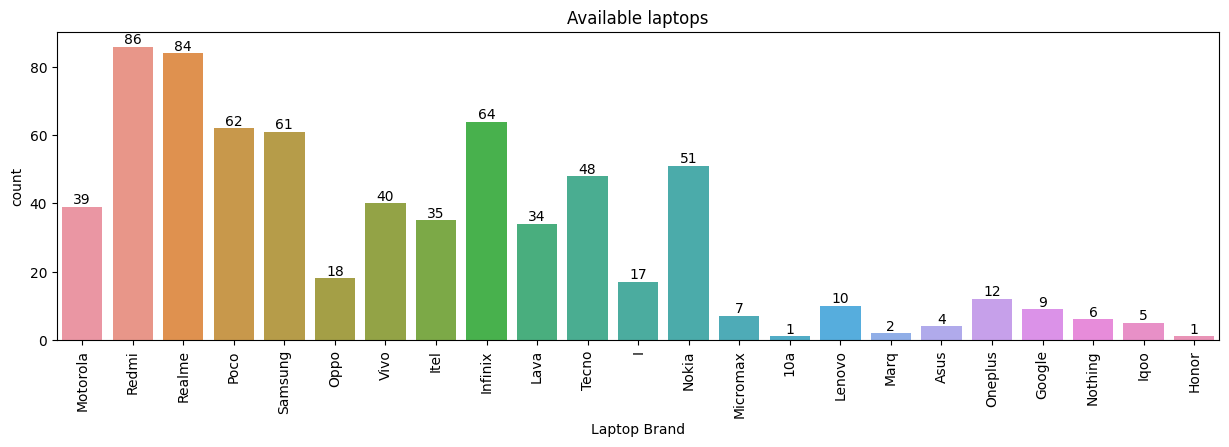

In [29]:
# Set the size of the plot figure
plt.figure(figsize=(15, 4))

# Create the countplot using Seaborn
# 'x='Brand'' specifies that the 'Brand' column from the 'mobile_dataset' DataFrame will be used for the x-axis.
# 'data=mobile_dataset' indicates the DataFrame to be used for data visualization.
ax = sns.countplot(x='Brand', data=mobile_dataset)

# Rotate the x-axis labels to make them more readable
plt.xticks(rotation=90)

# Set the plot title and axis labels
plt.title('Available laptops')
plt.xlabel('Laptop Brand')

# Add labels above each bar to show the count of laptops for each brand
for bars in ax.containers:
    ax.bar_label(bars)

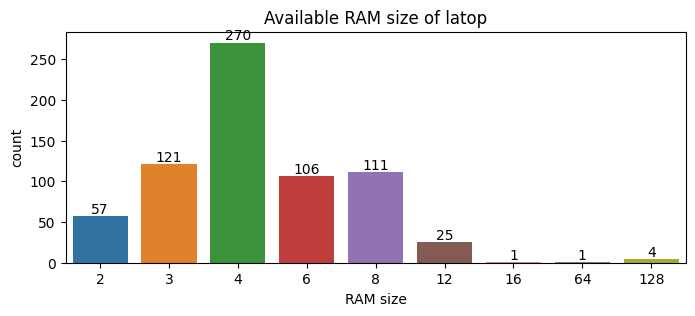

In [30]:
plt.figure(figsize=(8,3))
ax = sns.countplot(x='RAM_GB',data=mobile_dataset)
plt.title('Available RAM size of latop')
plt.xlabel('RAM size')
for bars in ax.containers:
    ax.bar_label(bars)

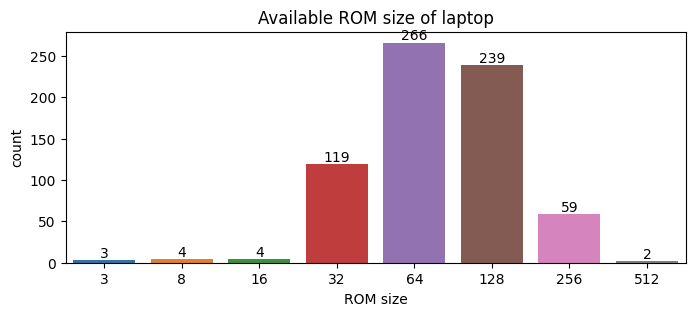

In [31]:
plt.figure(figsize=(8,3))
ax = sns.countplot(x='ROM_GB',data=mobile_dataset)
plt.title('Available ROM size of laptop')
plt.xlabel('ROM size')
for bars in ax.containers:
    ax.bar_label(bars)

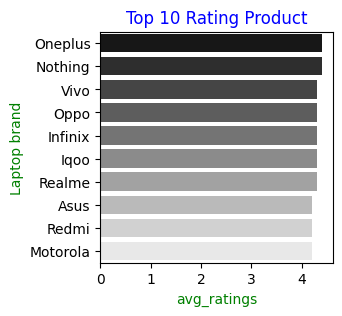

In [32]:
# Calculate the average ratings for each laptop brand and sort the results in descending order.
max_offer = mobile_dataset.groupby('Brand', as_index=False)['Ratings'].mean().round(1).sort_values(by='Ratings', ascending=False)

# Set the size of the plot figure
plt.figure(figsize=(3, 3))

# Create the bar plot using Seaborn
# 'y='Brand'' specifies that the 'Brand' column from 'max_offer' DataFrame will be used for the y-axis.
# 'x='Ratings'' indicates the 'Ratings' column from 'max_offer' DataFrame for the x-axis.
# 'data=max_offer.head(10)' uses only the top 10 rows of 'max_offer' DataFrame for data visualization.
# 'palette='gist_yarg_r'' sets the color palette for the bars in the plot.
sns.barplot(y='Brand', x='Ratings', data=max_offer.head(10), palette='gist_yarg_r')

# Set the plot title, y-axis label, and x-axis label
plt.title('Top 10 Rating Product', color='b')
plt.ylabel('Laptop brand', color='g')
plt.xlabel('avg_ratings', color='g')

# Display the plot
plt.show()

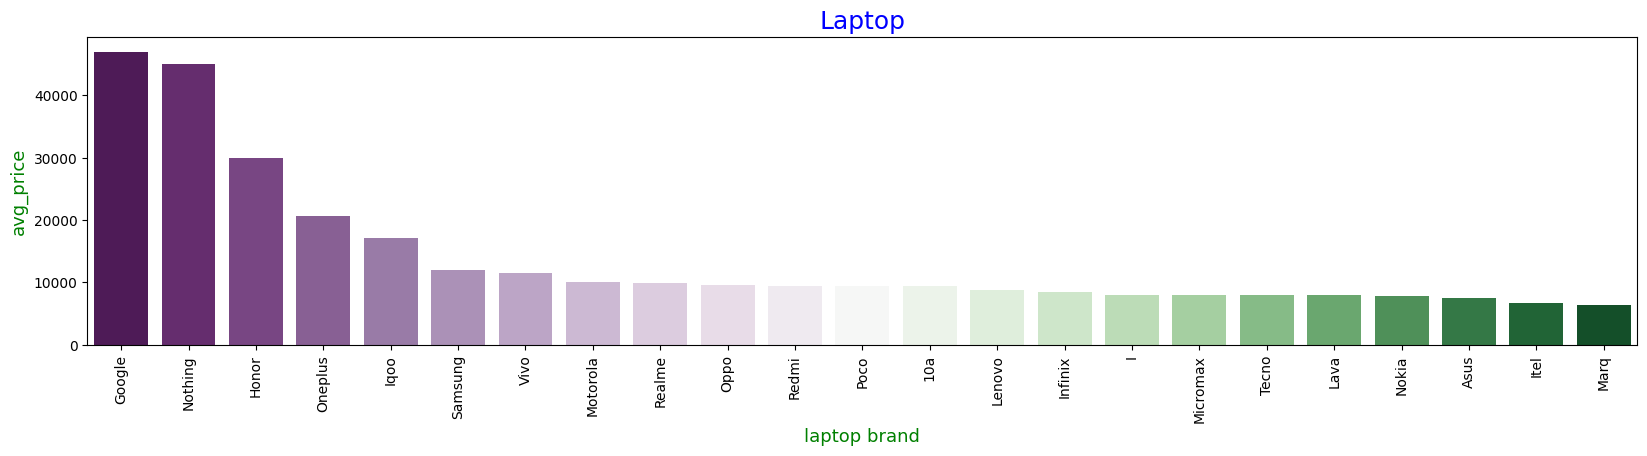

In [33]:
max_offer = mobile_dataset.groupby('Brand',as_index=False)['Selling_Price'].median().round(1).sort_values(by='Selling_Price',ascending=False)
plt.figure(figsize=(20,4))
sns.barplot(x='Brand',y='Selling_Price', data=max_offer, palette='PRGn')
plt.xticks(rotation=90)
plt.title('Laptop',color='b', fontsize=18)
plt.ylabel('avg_price', color='g', fontsize=13)
plt.xlabel('laptop brand', color='g',fontsize=13)
plt.show()

In [34]:
# Filter the 'mobile_dataset' DataFrame to find the row(s) with the minimum selling price.
# The 'min(mobile_dataset.Selling_Price)' calculates the minimum value in the 'Selling_Price' column.
# The result is used to filter the DataFrame and find the row(s) with the minimum selling price.
min_price = mobile_dataset[mobile_dataset.Selling_Price == min(mobile_dataset.Selling_Price)]

# Use the custom function 'Mymodule.formating_DataFrame()' to format and display the minimum price information.
# The function takes the 'min_price' DataFrame as input and sets the title of the formatted output to 'Minimum price of laptop'.
Mymodule.formating_DataFrame(min_price, title='Minimum price of laptop')

                                        Minimum price of laptop
+-----------------------------------------------------------------------------------------------------+
| Product         | Brand | product_color | RAM_GB | ROM_GB | Offer | Ratings | Selling_Price | Total |
+-----------------------------------------------------------------------------------------------------+
| Nokia C01 Plus  | Nokia | Grey          | 2      | 32     | 32    | 3.8     | 5390          | 7999  | 
+-----------------------------------------------------------------------------------------------------+


In [35]:
# The 'add_rating_features()' function is defined to add additional rating features to the 'Ratings' column.
# The function takes a numeric input 'num' (assumed to be a string representation of a rating) and returns a modified string.
def add_rating_features(num):
    if float(num) >= 4.5 and float(num) <= 5.0:
        return num + '*****'
    elif float(num) >= 4.0 and float(num) < 4.5:
        return num + '****'
    elif float(num) >= 3.0 and float(num) < 4.0:
        return num + '***'
    elif float(num) >= 2.0 and float(num) < 3.0:
        return num + '**'
    else:
        return num + '*'

# Filter the 'mobile_dataset' DataFrame to find the row(s) with the maximum selling price.
# The 'mobile_dataset.Selling_Price.median()' calculates the median value in the 'Selling_Price' column.
# The result is used to filter the DataFrame and find the row(s) with the maximum selling price.
max_price = mobile_dataset[mobile_dataset.Selling_Price == mobile_dataset.Selling_Price.median()]

# Drop duplicate rows based on specific columns to ensure unique entries.
max_price.drop_duplicates(subset=['Product', 'Brand', 'product_color', 'RAM_GB', 'ROM_GB', 'Offer', 'Ratings', 'Selling_Price', 'Total'], inplace=True)

# Convert 'Offer', 'Selling_Price', 'Total', and 'Ratings' columns to specific data types and format them accordingly.
max_price.Offer = max_price.Offer.astype(str) + '%'
max_price.Selling_Price = '₹' + max_price.Selling_Price.astype(str)
max_price.Total = '₹' + max_price.Total.astype(str)
max_price.Ratings = max_price.Ratings.astype(str)
max_price.Ratings = max_price.Ratings.apply(add_rating_features)

# Get the number of rows (laptops) in the 'max_price' DataFrame for the title.
x_shape = max_price.shape[0]

# Use the custom function 'Mymodule.formating_DataFrame()' to format and display the 'max_price' DataFrame.
# The function takes the 'max_price' DataFrame as input, and the title of the formatted output includes the number of laptops.
Mymodule.formating_DataFrame(max_price, title=f'Average price of {x_shape}-laptops')

                                            Average price of 38-laptops
+------------------------------------------------------------------------------------------------------------------+
| Product               | Brand    | product_color   | RAM_GB | ROM_GB | Offer | Ratings  | Selling_Price | Total  |
+------------------------------------------------------------------------------------------------------------------+
| SAMSUNG GALAXY M13    | Samsung  | Midnight Blue   | 4      | 64     | 40%   | 4.2****  | ₹8999         | ₹14999 | 
| REDMI 9 Activ         | Redmi    | Metallic Purple | 4      | 64     | 18%   | 4.2****  | ₹8999         | ₹10999 | 
| Infinix Hot 10 Play   | Infinix  | Obsidian Black  | 4      | 64     | 18%   | 4.3****  | ₹8999         | ₹10999 | 
| itel S23              | Itel     | Chrome Silver   | 8      | 128    | 35%   | 4.1****  | ₹8999         | ₹13999 | 
| realme C11 2021       | Realme   | Cool Grey       | 4      | 64     | 10%   | 4.3****  | ₹8999        

In [36]:
# Define a list 'ram_type' containing the RAM sizes in GB that we want to filter for.
ram_type = [2, 4, 6, 8, 12, 16, 32]

# Filter the 'mobile_dataset' DataFrame to include only rows where the 'RAM_GB' column matches the RAM sizes in 'ram_type'.
# The 'isin()' method checks if the 'RAM_GB' values match any of the values in the 'ram_type' list.
data = mobile_dataset[mobile_dataset.RAM_GB.isin(ram_type)]

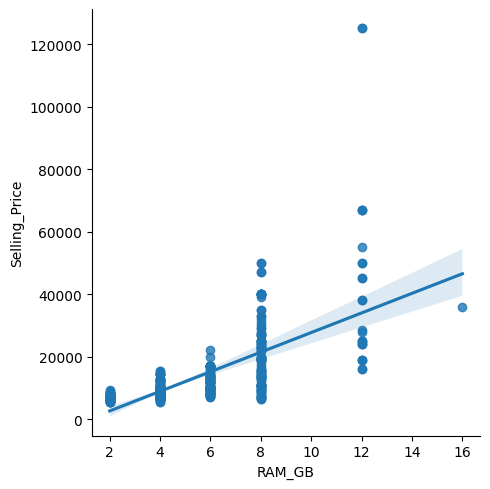

In [37]:
# Create a scatter plot with a linear regression line using Seaborn's 'lmplot()'
# 'x='RAM_GB'' specifies that the 'RAM_GB' column will be used for the x-axis (independent variable).
# 'y='Selling_Price'' specifies that the 'Selling_Price' column will be used for the y-axis (dependent variable).
# 'data=data' indicates the DataFrame 'data' to be used for data visualization.
sns.lmplot(x='RAM_GB', y='Selling_Price', data=data)

# The 'lmplot()' function automatically fits a linear regression line to the data points in the scatter plot.

# By default, 'lmplot()' creates a scatter plot with data points and overlays a linear regression line.

# The scatter plot shows the distribution of laptops' RAM sizes and their corresponding selling prices.

# The linear regression line provides an approximate linear relationship between RAM size and selling price.

# The slope of the line indicates how selling price changes with RAM size.

# The intercept of the line shows the predicted selling price when RAM size is zero (which is not practical in this context).

# The scatter plot and regression line help visualize any trends or correlations between RAM size and selling price.

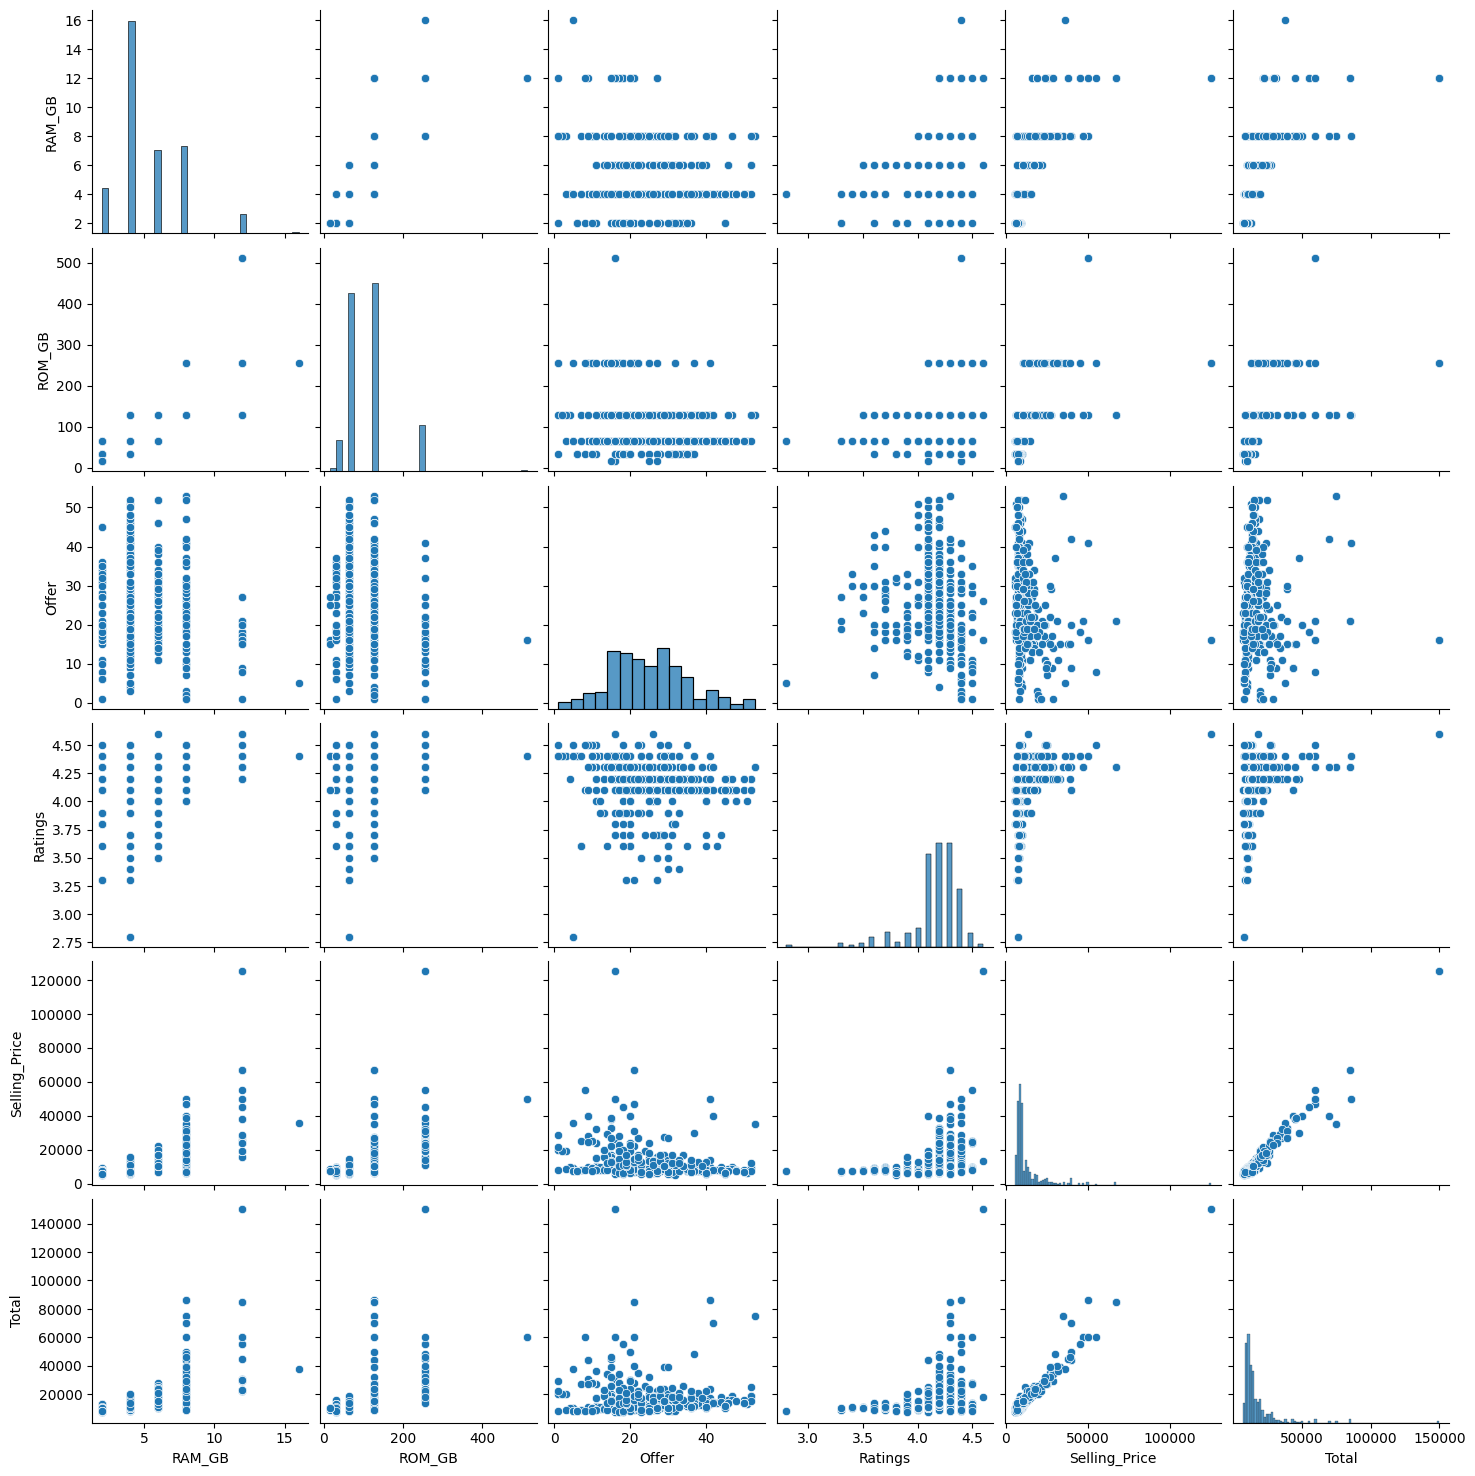

In [38]:
# Create a pair plot using Seaborn's 'pairplot()'
# The 'pairplot()' function automatically visualizes the pairwise relationships between numerical columns in the DataFrame.
# 'data=data' indicates the DataFrame 'data' to be used for data visualization.
sns.pairplot(data)

<Axes: xlabel='Selling_Price', ylabel='Count'>

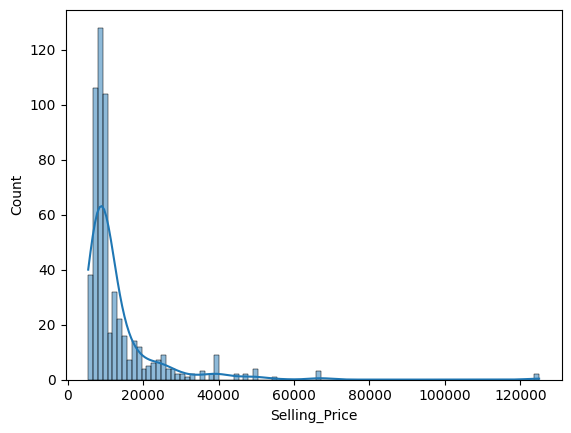

In [39]:
sns.histplot(x=data.Selling_Price, data=data, kde=True)

# Machine Learning Modelling

In [40]:
# A list of brand names to filter the DataFrame 'data' based on the 'Brand' column
brand_columns = ['Redmi', 'Realme', 'Infinix', 'Samsung', 'Poco', 'Vivo', 'Motorola', 'Lava', 'Nokia']

# Filter the DataFrame 'data' to keep only rows where the 'Brand' values are present in 'brand_columns'
data = data[data['Brand'].isin(brand_columns)]

# Reset the index of the DataFrame 'data' after filtering
data = data.reset_index(drop=True)

In [41]:
# Create a new DataFrame 'X' by dropping specified columns from the 'data' DataFrame
# The 'Product', 'product_color', 'Offer', 'Total', and 'Selling_Price' columns are dropped.
X = data.drop(columns=['Product', 'product_color', 'Offer', 'Total', 'Selling_Price'], axis=1)

# The 'y' variable is assigned the values from the 'Selling_Price' column of the 'data' DataFrame.
y = data.Selling_Price

In [42]:
# Perform one-hot encoding for the 'Brand' column in the DataFrame 'X'
# One-hot encoding converts categorical variables (like 'Brand') into binary vectors.
# It creates new columns for each unique value in the 'Brand' column, representing whether each row belongs to that brand or not.
X = pd.get_dummies(X, columns=['Brand'])

In [43]:
# Split the data into training and testing sets with a test size of 20% (0.2).
# This means 80% of the data will be used for training, and 20% will be used for testing.
# The function will randomly shuffle the data before splitting to ensure randomness.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [44]:
# Create an instance of the LinearRegression class, representing the linear regression model.
reg = LinearRegression()

# Train (fit) the linear regression model using the training data.
# The model will learn the coefficients (weights) for each feature to make predictions.
reg.fit(X_train, y_train)

LinearRegression()

In [45]:
# Assuming the Linear Regression model 'reg' has been trained and 'X_test' and 'y_test' are the testing data.

# Evaluate the Linear Regression model's performance on the testing data.
# The 'score' method calculates the coefficient of determination (R-squared) value.
# R-squared is a measure of how well the model explains the variability in the target variable.
# It takes values between 0 and 1, where 1 indicates a perfect fit and 0 indicates no linear relationship.
reg.score(X_test, y_test)

0.37590207399978237

# User Interaction

In [47]:
# Take user input for RAM size, ROM size, rating, and brand name
ram_size = int(input('Enter RAM size into GB: '))
rom_size = int(input('Enter ROM size into GB: '))
rating = float(input('Enter Rate choose perfer: '))
brand_choose = input('Enter the brand name: ')

# Check the user input for the brand name and set the 'brand' variable accordingly
if (brand_choose.lower()) == 'infinix':
    brand = 'Infinix'
    # Predict the selling price using the 'reg' model and the provided features for the 'Infinix' brand
    result = reg.predict([[ram_size, rom_size, rating, 1, 0, 0, 0, 0, 0, 0, 0, 0]])
elif (brand_choose.lower()) == 'lava':
    brand = 'Lava'
    # Predict the selling price using the 'reg' model and the provided features for the 'Lava' brand
    result = reg.predict([[ram_size, rom_size, rating, 0, 1, 0, 0, 0, 0, 0, 0, 0]])
# Repeat the same process for other brands
elif (brand_choose.lower()) == 'motorola':
    brand = 'Motorola'
    result = reg.predict([[ram_size, rom_size, rating, 0, 0, 1, 0, 0, 0, 0, 0, 0]])
elif (brand_choose.lower()) == 'nokia':
    brand = 'Nokia'
    result = reg.predict([[ram_size, rom_size, rating, 0, 0, 0, 1, 0, 0, 0, 0, 0]])
elif (brand_choose.lower()) == 'poco':
    brand = 'Poco'
    result = reg.predict([[ram_size, rom_size, rating, 0, 0, 0, 0, 1, 0, 0, 0, 0]])
elif (brand_choose.lower()) == 'realme':
    brand = 'Realme'
    result = reg.predict([[ram_size, rom_size, rating, 0, 0, 0, 0, 0, 1, 0, 0, 0]])
elif (brand_choose.lower()) == 'redmi':
    brand = 'Redmi'
    result = reg.predict([[ram_size, rom_size, rating, 0, 0, 0, 0, 0, 0, 1, 0, 0]])
elif (brand_choose.lower()) == 'samsung':
    brand = 'Samsung'
    result = reg.predict([[ram_size, rom_size, rating, 0, 0, 0, 0, 0, 0, 0, 1, 0]])
elif (brand_choose.lower()) == 'vivo':
    brand = 'Vivo'
    result = reg.predict([[ram_size, rom_size, rating, 0, 0, 0, 0, 0, 0, 0, 0, 1]])
else:
    # If the brand name doesn't match any of the specified options, display an error message
    print('Something went wrong')

# Round the predicted 'result' to one decimal place
result = round(result[0], 1)   # Convert to scalar values

Enter RAM size into GB: 8
Enter ROM size into GB: 128
Enter Rate choose perfer: 4.0
Enter the brand name: redmi


In [48]:
# Assuming 'result' is a variable containing the suggested price of the laptop
# The variable 'result' was calculated and assigned a value in the code, possibly based on a machine learning model prediction.

# Use the custom function 'Mymodule.design_text()' to display the suggested price of the laptop.
# The function takes a string as input and formats it in a stylized manner.

# The formatted text includes the suggested price denoted by 'result'.
# The price is represented in Indian Rupees (₹) using the '₹' symbol, followed by the corresponding value of 'result'.
Mymodule.design_text(f"Suggested Price of Laptop: ₹{result}")

+-------------------------------------+
| Suggested Price of Laptop: ₹14518.6 |
+-------------------------------------+


# Recommended Phone

In [49]:
# Filter data based on selling price and brand
predict_data = data[(data['Selling_Price'] <= result) & (data.Brand == brand)]

# Check if any laptops match the filter criteria
if predict_data is not None:
    # If there are laptops that match the criteria, sort them by selling price in descending order
    predict_data = predict_data.sort_values(by='Selling_Price', ascending=False)

    # Drop the 'Brand' column as it is no longer needed for prediction
    predict_data.drop('Brand', axis=1, inplace=True)

    # Convert RAM_GB and ROM_GB columns to string and add 'GB' at the end
    predict_data.RAM_GB = predict_data.RAM_GB.astype(str) + ' GB'
    predict_data.ROM_GB = predict_data.ROM_GB.astype(str) + ' GB'

    # Convert the 'Offer' column to string and add '%' at the end
    predict_data.Offer = predict_data.Offer.astype(str) + '% off'

    # Convert the 'Selling_Price' and 'Total' columns to string and add '₹' at the beginning
    predict_data.Selling_Price = '₹' + predict_data.Selling_Price.astype(str)
    predict_data.Total = '₹' + predict_data.Total.astype(str)

    # Display the formatted DataFrame containing the top 5 recommended laptops
    Mymodule.formating_DataFrame(predict_data.head(), title='5-Recommended Laptop')
else:
    # If there are no laptops that match the brand filter, filter only by selling price
    predict_data = data[data['Selling_Price'] <= result]

    # Drop the 'Brand' column as it is no longer needed for prediction
    predict_data.drop('Brand', axis=1, inplace=True)

    # Convert RAM_GB and ROM_GB columns to string and add 'GB' at the end
    predict_data.RAM_GB = predict_data.RAM_GB.astype(str) + ' GB'
    predict_data.ROM_GB = predict_data.ROM_GB.astype(str) + ' GB'

    # Convert the 'Offer' column to string and add '%' at the end
    predict_data.Offer = predict_data.Offer.astype(str) + '% off'

    # Convert the 'Selling_Price' and 'Total' columns to string and add '₹' at the beginning
    predict_data.Selling_Price = '₹' + predict_data.Selling_Price.astype(str)
    predict_data.Total = '₹' + predict_data.Total.astype(str)

    # Display the formatted DataFrame containing recommended laptops without brand filtering
    Mymodule.formating_DataFrame(predict_data, title='Recommended Laptop')

                                        5-Recommended Laptop
+--------------------------------------------------------------------------------------------------+
| Product        | product_color    | RAM_GB | ROM_GB | Offer   | Ratings | Selling_Price | Total  |
+--------------------------------------------------------------------------------------------------+
| REDMI Note 12  | Lunar Black      | 6 GB   | 128 GB | 33% off | 4.1     | ₹13999        | ₹20999 | 
| REDMI Note 12  | Sunrise Gold     | 6 GB   | 128 GB | 33% off | 4.1     | ₹13999        | ₹20999 | 
| REDMI 12 5G    | Pastel Blue      | 6 GB   | 128 GB | 25% off | 4.3     | ₹13400        | ₹17999 | 
| REDMI 12 5G    | Pastel Blue      | 6 GB   | 128 GB | 25% off | 4.3     | ₹13399        | ₹17999 | 
| REDMI 13c 5G   | Startrail Silver | 6 GB   | 128 GB | 26% off | 4.6     | ₹13299        | ₹17999 | 
+--------------------------------------------------------------------------------------------------+
